In [68]:
# Normalize headers, match tracks, and compute per-track volumes for N2
import re
import numpy as np
from pathlib import Path

area_path = Path(r"E:\\Todd\\OSR\\251128\\OSR compiled data all genotypes\\data\\compiled\\N2_compiled_area.csv")
length_path = Path(r"E:\\Todd\\OSR\\251128\\OSR compiled data all genotypes\\data\\compiled\\N2_compiled_length.csv")
fit_path = Path(r"E:\\Todd\\OSR\\251128\\OSR compiled data all genotypes\\data\\compiled\\N2_compiled_fit.csv")
volume_path = Path(r"E:\\Todd\\OSR\\251128\\OSR compiled data all genotypes\\data\\compiled\\N2_compiled_volume.csv")

area_df = pd.read_csv(area_path)
length_df = pd.read_csv(length_path)
fit_df = pd.read_csv(fit_path)
time_series = area_df['Time']

def normalize(col):
    col = str(col).strip()
    col = re.sub(r'(?i)(area|length|fit)', '', col)
    col = re.sub(r'[^0-9a-z]+', '_', col.lower())
    return col.strip('_')

area_map = {normalize(c): c for c in area_df.columns if c not in ['Frame','Time']}
length_map = {normalize(c): c for c in length_df.columns if c not in ['Frame','Time']}
fit_map = {normalize(c): c for c in fit_df.columns if c not in ['Frame','Time']}
common_keys = sorted(area_map.keys() & length_map.keys() & fit_map.keys())
print(f"Matched {len(common_keys)} tracks before filtering")

volume_df = area_df[['Frame','Time']].copy()
retained_keys = []
for key in common_keys:
    a_col = area_map[key]
    l_col = length_map[key]
    f_col = fit_map[key]
    with np.errstate(divide='ignore', invalid='ignore'):
        volume = (np.pi * (area_df[a_col]**2)) / (4 * length_df[l_col])
    volume = volume.where(fit_df[f_col] >= 0.9)
    valid_mask = volume.notna()
    if not valid_mask.any():
        continue
    valid_times = time_series[valid_mask]
    valid_volume = volume[valid_mask]
    duration = valid_times.max() - valid_times.min()
    initial_volume = valid_volume.iloc[0]
    if pd.notna(initial_volume) and initial_volume >= 1.5 and duration >= 400:
        volume_df[key] = volume
        retained_keys.append(key)

print(f"Retained {len(retained_keys)} tracks with initial volume >= 1.5, duration >= 400 s, and fit >= 0.9")

volume_df.to_csv(volume_path, index=False)
print(f"Saved volume data to {volume_path}")
volume_df.head()

Matched 271 tracks before filtering
Retained 16 tracks with initial volume >= 1.5, duration >= 400 s, and fit >= 0.9
Saved volume data to E:\Todd\OSR\251128\OSR compiled data all genotypes\data\compiled\N2_compiled_volume.csv


Matched 271 tracks before filtering
Retained 16 tracks with initial volume >= 1.5, duration >= 400 s, and fit >= 0.9
Saved volume data to E:\Todd\OSR\251128\OSR compiled data all genotypes\data\compiled\N2_compiled_volume.csv


,Frame,Time,wt3_5500001_101,wt3_5500001_102,wt3_5500001_111,wt3_5500001_152,wt3_5500001_2,wt3_5500001_5,wt3_5500001_74,wt3_5500001_8,wt3_5500001_9,wt_550_0003_1,wt_550_0003_11,wt_550_0003_2,wt_550_0003_3,wt_550_0003_4,wt_550_0003_6,wt_550_0003_60
0,1,0.000000,NaN,NaN,NaN,NaN,2.379239e+06,2.347782e+06,NaN,2.344542e+06,2.733733e+06,NaN,NaN,3.789175e+06,2.524813e+06,3.660740e+06,3.372500e+06,NaN
1,2,0.071429,NaN,NaN,NaN,NaN,2.619042e+06,2.570474e+06,NaN,2.564524e+06,2.713259e+06,3.524172e+06,NaN,3.812530e+06,3.091745e+06,3.573579e+06,3.650062e+06,NaN
2,3,0.142857,NaN,NaN,NaN,NaN,2.483998e+06,2.459052e+06,NaN,2.672680e+06,2.758975e+06,3.338642e+06,NaN,3.747480e+06,2.638653e+06,NaN,3.372172e+06,NaN
3,4,0.214286,NaN,NaN,NaN,NaN,2.552436e+06,2.640181e+06,NaN,2.558509e+06,2.644640e+06,3.317984e+06,NaN,4.026900e+06,2.932009e+06,3.789634e+06,3.472031e+06,NaN
4,5,0.285714,NaN,NaN,NaN,NaN,2.407997e+06,2.318174e+06,NaN,2.159883e+06,2.917590e+06,3.281932e+06,NaN,4.109425e+06,3.222380e+06,3.676710e+06,3.309402e+06,NaN


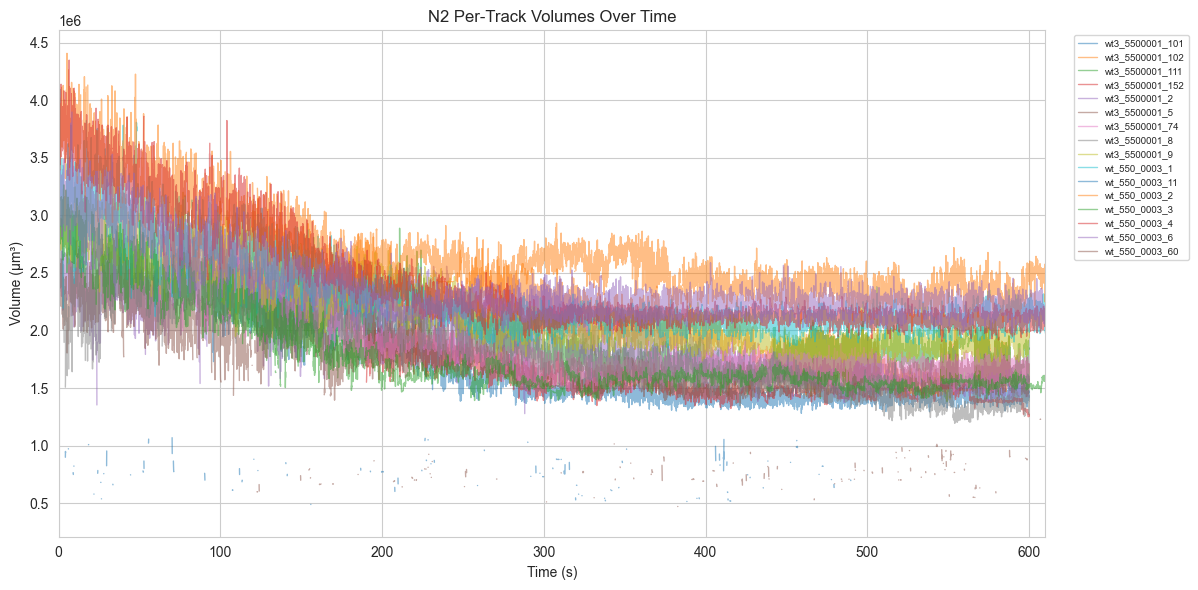

In [69]:
# Plot per-track volumes over time for N2
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12,6))

volume_data = pd.read_csv(volume_path)
time = volume_data['Time']
track_cols = [c for c in volume_data.columns if c not in ['Frame','Time']]

for col in track_cols:
    ax.plot(time, volume_data[col], alpha=0.5, linewidth=1, label=col)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Volume (μm³)')
ax.set_title('N2 Per-Track Volumes Over Time')
ax.set_xlim(time.min(), time.max())
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, fontsize=7)
plt.tight_layout()
plt.show()

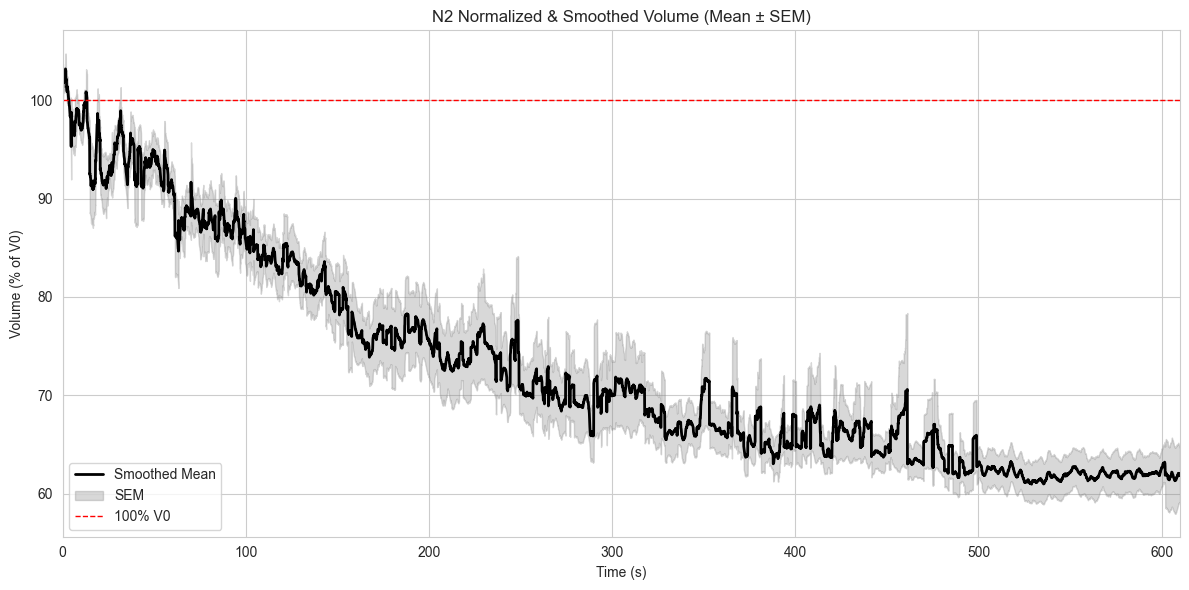

,Time,Mean,SEM
0,0.000000,97.492715,2.034484
1,0.071429,101.657754,1.867345
2,0.142857,101.275278,1.820476
3,0.214286,101.906103,1.799165
4,0.285714,101.720816,1.371774


In [70]:
# Normalize to V0 (mean of first 5 s), smooth, and plot mean ± SEM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

volume_data = pd.read_csv(volume_path)
time = volume_data['Time']
track_cols = [c for c in volume_data.columns if c not in ['Frame','Time']]
if not track_cols:
    raise ValueError('No tracks remain after filtering to compute normalized volumes.')

V0_WINDOW = 5.0
v0_mask = time <= V0_WINDOW
norm_data = volume_data[['Frame','Time']].copy()
for col in track_cols:
    v0 = volume_data.loc[v0_mask, col].mean()
    if pd.notna(v0) and v0 > 0:
        norm_data[col] = (volume_data[col] / v0) * 100.0
    else:
        norm_data[col] = np.nan

SMOOTH_WINDOW = 28  # frames for rolling mean smoothing
smoothed_values = (
    norm_data[track_cols]
    .rolling(window=SMOOTH_WINDOW, min_periods=1)
    .mean()
)
smoothed_norm = pd.concat([norm_data[['Frame','Time']], smoothed_values], axis=1)

summary = pd.DataFrame({
    'Time': time,
    'Mean': smoothed_norm[track_cols].mean(axis=1, skipna=True),
    'SEM': smoothed_norm[track_cols].sem(axis=1, skipna=True)
})

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(summary['Time'], summary['Mean'], color='black', linewidth=2, label='Smoothed Mean')
ax.fill_between(summary['Time'], summary['Mean'] - summary['SEM'], summary['Mean'] + summary['SEM'], color='grey', alpha=0.3, label='SEM')
ax.axhline(100, color='red', linestyle='--', linewidth=1, label='100% V0')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Volume (% of V0)')
ax.set_title('N2 Normalized & Smoothed Volume (Mean ± SEM)')
ax.set_xlim(time.min(), time.max())
ax.legend()
plt.tight_layout()
plt.show()

summary.head()

dr170: saved 9 tracks to dr170_compiled_volume.csv
dr170_dr180: saved 13 tracks to dr170_dr180_compiled_volume.csv
dr180: saved 10 tracks to dr180_compiled_volume.csv
N2: saved 16 tracks to N2_compiled_volume.csv
osm6_p811: saved 20 tracks to osm6_p811_compiled_volume.csv
p811_dr170: saved 19 tracks to p811_dr170_compiled_volume.csv


,Genotype,Tracks Retained
0,N2,10
1,dr170,8
2,dr170_dr180,12
3,dr180,9
4,osm6_p811,20
5,p811_dr170,19


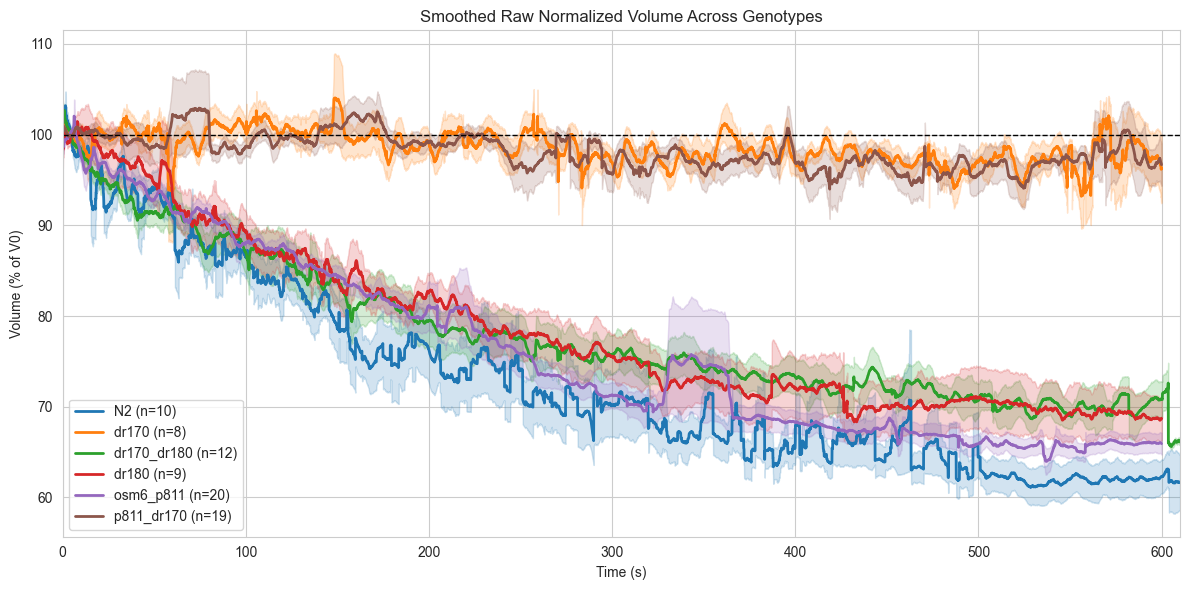

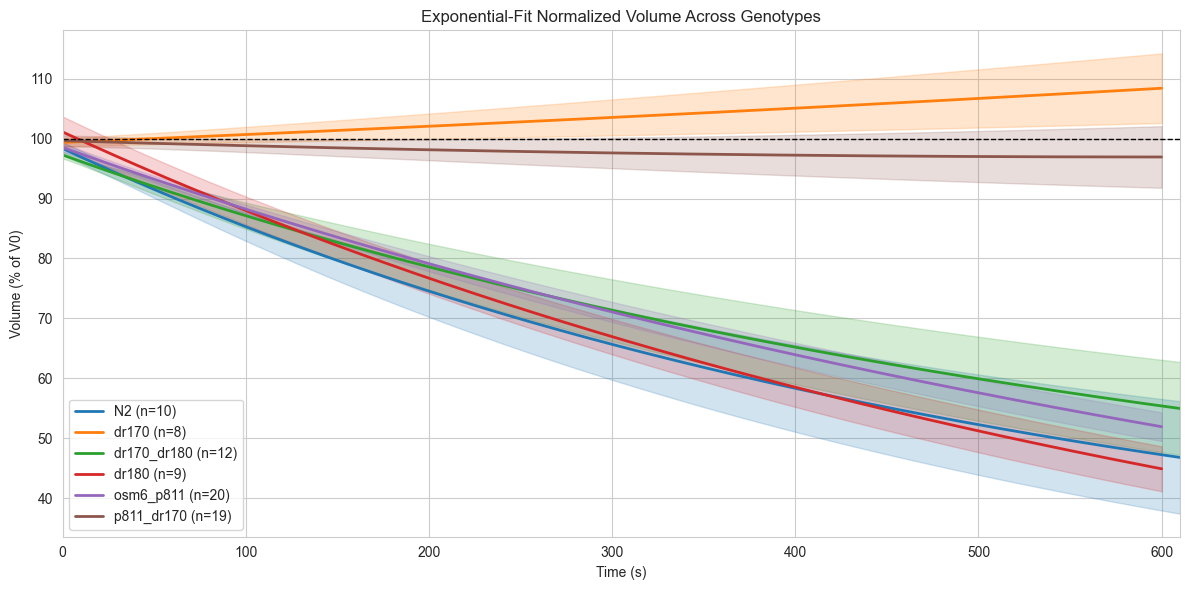

In [74]:
# Run the volume pipeline for all genotypes and plot normalized means together
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

COMPILED_DIR = area_path.parent
FIT_THRESHOLD = 0.9
INITIAL_VOLUME_MIN = 1.5
MIN_DURATION = 400
V0_WINDOW = 5.0
SMOOTH_WINDOW = 56  # frames for smoothing raw normalized curves
FIT_WINDOW = (0, 120)  # seconds to use for per-track exponential fits (None means full range)
MIN_FIT_POINTS = 15

def normalize_header(col):
    col = str(col).strip()
    col = re.sub(r'(?i)(area|length|fit)', '', col)
    col = re.sub(r'[^0-9a-z]+', '_', col.lower())
    return col.strip('_')

genotype_results = []
for area_file in sorted(COMPILED_DIR.glob('*compiled_area.csv')):
    genotype = re.sub(r'[\s_]*compiled_area$', '', area_file.stem, flags=re.IGNORECASE)
    length_file = area_file.with_name(area_file.name.replace('compiled_area', 'compiled_length'))
    fit_file = area_file.with_name(area_file.name.replace('compiled_area', 'compiled_fit'))
    if not (length_file.exists() and fit_file.exists()):
        print(f"Skipping {genotype}: missing length or fit file")
        continue

    area_df = pd.read_csv(area_file)
    length_df = pd.read_csv(length_file)
    fit_df = pd.read_csv(fit_file)
    time_series = area_df['Time']

    area_map = {normalize_header(c): c for c in area_df.columns if c not in ['Frame','Time']}
    length_map = {normalize_header(c): c for c in length_df.columns if c not in ['Frame','Time']}
    fit_map = {normalize_header(c): c for c in fit_df.columns if c not in ['Frame','Time']}
    common_keys = sorted(area_map.keys() & length_map.keys() & fit_map.keys())
    if not common_keys:
        print(f"Skipping {genotype}: no common tracks")
        continue

    volume_df = area_df[['Frame','Time']].copy()
    retained_keys = []
    for key in common_keys:
        a_col = area_map[key]
        l_col = length_map[key]
        f_col = fit_map[key]
        with np.errstate(divide='ignore', invalid='ignore'):
            volume = (np.pi * (area_df[a_col]**2)) / (4 * length_df[l_col])
        volume = volume.where(fit_df[f_col] >= FIT_THRESHOLD)
        valid_mask = volume.notna()
        if not valid_mask.any():
            continue
        valid_times = time_series[valid_mask]
        valid_volume = volume[valid_mask]
        duration = valid_times.max() - valid_times.min()
        initial_volume = valid_volume.iloc[0]
        if pd.notna(initial_volume) and initial_volume >= INITIAL_VOLUME_MIN and duration >= MIN_DURATION:
            volume_df[key] = volume
            retained_keys.append(key)

    track_cols = [c for c in volume_df.columns if c not in ['Frame','Time']]
    if not track_cols:
        print(f"Skipping {genotype}: no tracks passed the filters")
        continue

    volume_path = area_file.with_name(area_file.name.replace('compiled_area', 'compiled_volume'))
    volume_df.to_csv(volume_path, index=False)
    print(f"{genotype}: saved {len(track_cols)} tracks to {volume_path.name}")

    v0_mask = time_series <= V0_WINDOW
    norm_df = volume_df[['Frame','Time']].copy()
    for col in track_cols:
        v0 = volume_df.loc[v0_mask, col].mean()
        if pd.notna(v0) and v0 > 0:
            norm_df[col] = (volume_df[col] / v0) * 100.0
        else:
            norm_df[col] = np.nan

    smoothed_values = (
        norm_df[track_cols]
        .rolling(window=SMOOTH_WINDOW, min_periods=1)
        .mean()
    )
    raw_summary_df = pd.DataFrame({
        'Time': time_series,
        'Mean': smoothed_values.mean(axis=1, skipna=True),
        'SEM': smoothed_values.sem(axis=1, skipna=True)
    })

    fit_predictions = {}
    param_rows = []
    for col in track_cols:
        series = norm_df[col]
        mask = series.notna() & (series > 0)
        start, end = FIT_WINDOW
        if start is not None:
            mask &= time_series >= start
        if end is not None:
            mask &= time_series <= end
        if mask.sum() < MIN_FIT_POINTS:
            continue
        times = time_series[mask].to_numpy()
        values = series[mask].to_numpy()
        k, log_a = np.polyfit(times, np.log(values), deg=1)
        a = np.exp(log_a)
        fit_vals = a * np.exp(k * time_series.to_numpy())
        fit_predictions[col] = fit_vals
        param_rows.append({'Track': col, 'A': a, 'k': k})

    if not fit_predictions:
        print(f"Skipping {genotype}: no tracks produced valid exponential fits")
        continue

    fitted_df = pd.DataFrame(fit_predictions)
    fit_summary_df = pd.DataFrame({
        'Time': time_series,
        'Mean': fitted_df.mean(axis=1, skipna=True),
        'SEM': fitted_df.sem(axis=1, skipna=True)
    })
    param_table = pd.DataFrame(param_rows)
    genotype_results.append({
        'genotype': genotype,
        'track_count': len(fit_predictions),
        'raw_summary': raw_summary_df,
        'fit_summary': fit_summary_df,
        'param_table': param_table
    })

if not genotype_results:
    raise ValueError('No genotypes produced valid tracks after filtering and fitting.')

genotype_results.sort(key=lambda x: x['genotype'])
count_report = pd.DataFrame([{
    'Genotype': res['genotype'],
    'Tracks Retained': res['track_count']
} for res in genotype_results])
display(count_report)

palette = sns.color_palette('tab10', len(genotype_results))
fig_raw, ax_raw = plt.subplots(figsize=(12,6))
raw_time_min = min(res['raw_summary']['Time'].min() for res in genotype_results)
raw_time_max = max(res['raw_summary']['Time'].max() for res in genotype_results)
for color, res in zip(palette, genotype_results):
    raw_summary = res['raw_summary']
    label = f"{res['genotype']} (n={res['track_count']})"
    ax_raw.plot(raw_summary['Time'], raw_summary['Mean'], color=color, linewidth=2, label=label)
    ax_raw.fill_between(
        raw_summary['Time'],
        raw_summary['Mean'] - raw_summary['SEM'],
        raw_summary['Mean'] + raw_summary['SEM'],
        color=color,
        alpha=0.2,
    )
ax_raw.axhline(100, color='black', linestyle='--', linewidth=1)
ax_raw.set_xlabel('Time (s)')
ax_raw.set_ylabel('Volume (% of V0)')
ax_raw.set_title('Smoothed Raw Normalized Volume Across Genotypes')
ax_raw.set_xlim(raw_time_min, raw_time_max)
ax_raw.legend()
plt.tight_layout()
plt.show()

fig_fit, ax_fit = plt.subplots(figsize=(12,6))
fit_time_min = min(res['fit_summary']['Time'].min() for res in genotype_results)
fit_time_max = max(res['fit_summary']['Time'].max() for res in genotype_results)
for color, res in zip(palette, genotype_results):
    fit_summary = res['fit_summary']
    label = f"{res['genotype']} (n={res['track_count']})"
    ax_fit.plot(fit_summary['Time'], fit_summary['Mean'], color=color, linewidth=2, label=label)
    ax_fit.fill_between(
        fit_summary['Time'],
        fit_summary['Mean'] - fit_summary['SEM'],
        fit_summary['Mean'] + fit_summary['SEM'],
        color=color,
        alpha=0.2,
    )
ax_fit.axhline(100, color='black', linestyle='--', linewidth=1)
ax_fit.set_xlabel('Time (s)')
ax_fit.set_ylabel('Volume (% of V0)')
ax_fit.set_title('Exponential-Fit Normalized Volume Across Genotypes')
ax_fit.set_xlim(fit_time_min, fit_time_max)
ax_fit.legend()
plt.tight_layout()
plt.show()

In [75]:
# Fit normalized mean curves to estimate volume-loss rates (linear and exponential)
import numpy as np
import pandas as pd

if 'genotype_results' not in globals() or not genotype_results:
    raise ValueError('Run the multi-genotype pipeline cell first to populate genotype_results.')

fit_window = (0, None)  # (start_time, end_time) in seconds; None uses full range
fit_rows = []
for res in genotype_results:
    fit_summary = res['fit_summary'][['Time','Mean']].dropna()
    if fit_summary.empty:
        continue
    start, end = fit_window
    mask = fit_summary['Time'] >= (start or 0)
    if end is not None:
        mask &= fit_summary['Time'] <= end
    subset = fit_summary.loc[mask]
    if len(subset) < 2:
        continue

    # Linear fit (Mean = m * t + b)
    lin_slope, lin_intercept = np.polyfit(subset['Time'], subset['Mean'], deg=1)

    # Exponential fit (Mean = A * exp(k * t))
    exp_subset = subset[subset['Mean'] > 0]
    if len(exp_subset) >= 2:
        k, log_a = np.polyfit(exp_subset['Time'], np.log(exp_subset['Mean']), deg=1)
        a = np.exp(log_a)
        half_life = np.log(2) / (-k) if k < 0 else np.nan
    else:
        k = np.nan
        a = np.nan
        half_life = np.nan

    fit_rows.append({
        'Genotype': res['genotype'],
        'Tracks Retained': res['track_count'],
        'Linear slope (%V0/s)': lin_slope,
        'Linear intercept (%V0)': lin_intercept,
        'Exponential A (%V0)': a,
        'Exponential k (1/s)': k,
        'Half-life (s)': half_life
    })

fit_report = pd.DataFrame(fit_rows).sort_values('Genotype')
display(fit_report)

print('Negative linear slopes or negative exponential k values indicate volume loss. Adjust fit_window to focus on specific intervals if needed.')

,Genotype,Tracks Retained,Linear slope (%V0/s),Linear intercept (%V0),Exponential A (%V0),Exponential k (1/s),Half-life (s)
0,N2,10,-0.082637,92.883444,95.923768,-0.001220,568.230112
1,dr170,8,0.015064,99.131135,99.199084,0.000145,NaN
2,dr170_dr180,12,-0.068047,93.462562,95.355892,-0.000934,742.336386
3,dr180,9,-0.092450,96.692544,100.689814,-0.001353,512.278866
4,osm6_p811,20,-0.076924,95.531521,98.104307,-0.001067,649.567922
5,p811_dr170,19,-0.004523,99.196213,99.199763,-0.000046,15021.439493


Negative linear slopes or negative exponential k values indicate volume loss. Adjust fit_window to focus on specific intervals if needed.


,Mean k (1/s),SE k (1/s),Tracks
Genotype,,,
N2,-0.001451,0.000280,10
dr170,0.000127,0.000092,8
dr170_dr180,-0.001135,0.000258,12
dr180,-0.001391,0.000129,9
osm6_p811,-0.001106,0.000092,20
p811_dr170,-0.000087,0.000093,19


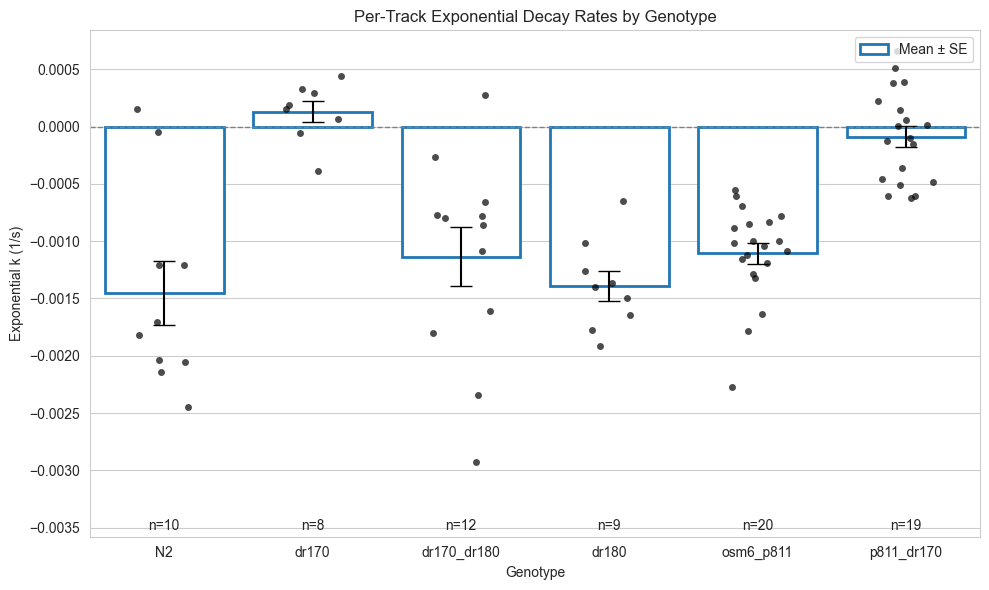

One-way ANOVA F=16.513, p=7.8689e-11


,Comparison,t statistic,raw p-value,Holm-adjusted p-value
14,osm6_p811 vs p811_dr170,-7.799573,2.524196e-09,3.786294e-08
7,dr170 vs osm6_p811,9.489057,5.799244e-09,8.118942e-08
6,dr170 vs dr180,9.598791,1.517415e-07,1.972640e-06
13,dr180 vs p811_dr170,-8.214536,3.229452e-07,3.875343e-06
0,N2 vs dr170,-5.352536,2.428862e-04,2.671748e-03
5,dr170 vs dr170_dr180,4.617856,4.278792e-04,4.278792e-03
4,N2 vs p811_dr170,-4.621458,7.375867e-04,6.638280e-03
11,dr170_dr180 vs p811_dr170,-3.829734,1.865162e-03,1.492130e-02
12,dr180 vs osm6_p811,-1.794293,9.114235e-02,6.379965e-01
8,dr170 vs p811_dr170,1.644235,1.154888e-01,6.929327e-01


In [ ]:
# Visualize per-track exponential k values and run group comparisons
import itertools
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

if 'genotype_results' not in globals() or not genotype_results:
    raise ValueError('Run the multi-genotype pipeline cell first to populate genotype_results.')

k_rows = []
for res in genotype_results:
    params = res['param_table'][['Track', 'k']].copy()
    params['Genotype'] = res['genotype']
    k_rows.append(params)

if not k_rows:
    raise ValueError('No per-track exponential parameters available to analyze.')

k_df = pd.concat(k_rows, ignore_index=True)
k_df = k_df.dropna(subset=['k'])
if k_df.empty:
    raise ValueError('All exponential k values are NaN; cannot generate plot or statistics.')

summary_stats = (
    k_df.groupby('Genotype')['k']
    .agg(['mean', 'sem', 'count'])
    .rename(columns={'mean': 'Mean k (1/s)', 'sem': 'SE k (1/s)', 'count': 'Tracks'})
)
display(summary_stats)

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10,6))
order = summary_stats.index
x = np.arange(len(order))
means = summary_stats['Mean k (1/s)'].values
ses = summary_stats['SE k (1/s)'].fillna(0).values
bar_container = ax.bar(
    x,
    means,
    yerr=ses,
    capsize=8,
    color='white',
    edgecolor='tab:blue',
    linewidth=2,
    label='Mean ± SE'
)
sns.stripplot(data=k_df, x='Genotype', y='k', order=order, color='black', alpha=0.7, jitter=0.2, ax=ax)
ax.axhline(0, color='grey', linestyle='--', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(order)
ax.set_ylabel('Exponential k (1/s)')
ax.set_title('Per-Track Exponential Decay Rates by Genotype')

y_min, y_max = ax.get_ylim()
y_range = y_max - y_min if y_max > y_min else 1.0
for xi, genotype in zip(x, order):
    n = int(summary_stats.loc[genotype, 'Tracks'])
    ax.text(xi, y_min - 0.08 * y_range, f"n={n}", ha='center', va='top', fontsize=10)
ax.set_ylim(y_min - 0.12 * y_range, y_max)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

groups = [group['k'].values for _, group in k_df.groupby('Genotype')]
group_names = list(k_df.groupby('Genotype').groups.keys())
anova_result = None
if len(groups) >= 2:
    anova_result = stats.f_oneway(*groups)
    print(f"One-way ANOVA F={anova_result.statistic:.3f}, p={anova_result.pvalue:.4e}")
else:
    print('Not enough genotypes to run ANOVA (need at least two groups).')

pairwise_rows = []
if len(groups) >= 2:
    comparisons = list(itertools.combinations(order, 2))
    raw_pvals = []
    tstats = []
    for g1, g2 in comparisons:
        data1 = k_df.loc[k_df['Genotype'] == g1, 'k']
        data2 = k_df.loc[k_df['Genotype'] == g2, 'k']
        t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False, nan_policy='omit')
        raw_pvals.append(p_val)
        tstats.append(t_stat)

    # Holm-Bonferroni correction
    order_idx = np.argsort(raw_pvals)
    adjusted = [None] * len(raw_pvals)
    m = len(raw_pvals)
    for rank, idx in enumerate(order_idx):
        adjusted[idx] = min((m - rank) * raw_pvals[idx], 1.0)

    for (g1, g2), t_stat, raw_p, adj_p in zip(comparisons, tstats, raw_pvals, adjusted):
        pairwise_rows.append({
            'Comparison': f"{g1} vs {g2}",
            't statistic': t_stat,
            'raw p-value': raw_p,
            'Holm-adjusted p-value': adj_p,
            'Significant (p<0.05)': 'Yes' if adj_p < 0.05 else 'No'
        })

if pairwise_rows:
    pairwise_df = pd.DataFrame(pairwise_rows).sort_values('Holm-adjusted p-value')
    display(pairwise_df)
else:
    print('Pairwise tests were not run (need at least two genotypes).')